 # Librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import os

from collections import defaultdict
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

2024-12-15 11:24:01.197502: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-15 11:24:01.218914: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 11:24:01.322807: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-15 11:24:01.322848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-15 11:24:01.341182: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Funciones

In [3]:
def remove_correlated_features(X, threshold):
    # Eliminar columnas constantes
    X = X.loc[:, X.apply(pd.Series.nunique) > 1]
    # Calcular la matriz de correlación absoluta
    corr_matrix = X.corr().abs()
    # Seleccionar la parte superior de la matriz de correlación
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Identificar las columnas a eliminar para evitar la correlación alta
    to_drop = set()
    for column in upper.columns:
        # Obtener las columnas correlacionadas con la actual
        correlated_columns = [col for col in upper.columns if upper[col][column] > threshold]
        # Si hay columnas correlacionadas, eliminar todas excepto la primera
        if correlated_columns:
            to_drop.update(correlated_columns[1:])

    # Eliminar las columnas correlacionadas
    return X.drop(columns=list(to_drop), errors='ignore')

In [4]:
def get_frequent_features(features_array):
# seleccionar los m features que mas se repitan en cada experimento
    flattened = np.concatenate([np.unique(row) for row in features_array])
    unique_feats, counts = np.unique(flattened, return_counts=True)
    mean_feats = sum(len(row) for row in features_array) / len(features_array)
    print('Mean features:', mean_feats)

    sorted_indices = np.argsort(-counts)  # Índices ordenados por frecuencia (descendente)
    freq_feat = unique_feats[sorted_indices][:int(np.ceil(mean_feats))]

    return freq_feat.tolist()

In [5]:
def dnn_model(num_entradas, num_clases):
    model = Sequential()
    # Capa de entrada
    model.add(InputLayer(input_shape=(num_entradas,)))
    # Capas ocultas
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    # Capa de salida
    if num_clases == 2:
        # Para clasificación binaria
        model.add(Dense(1, activation='sigmoid'))
        loss = 'binary_crossentropy'
    else:
        # Para clasificación multiclase
        model.add(Dense(num_clases, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'
    # Compilar el modelo
    model.compile(optimizer='RMSprop', loss=loss, metrics=['accuracy'])
    # devolver modelo compilado
    return model

In [6]:
def cnn_model_1d(n_features, num_clases):
    model = Sequential()
    # Capa de entrada
    # model.add(InputLayer(input_shape=(input_shape,)))
    # Capa de entrada y primeras capas convolucionales 1D
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_features, 1)))
    # model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(64, kernel_size=3, activation='relu'))

    model.add(Conv1D(128, kernel_size=3, activation='relu'))

    # Aplanar el volumen para conectarlo con capas densas
    model.add(Flatten())

    # Capas densas
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))

    # Capa de salida
    if num_clases == 2:
        # Para clasificación binaria
        model.add(Dense(1, activation='sigmoid'))
        loss = 'binary_crossentropy'
    else:
        # Para clasificación multiclase
        model.add(Dense(num_clases, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'

    # Compilar el modelo
    model.compile(optimizer='RMSprop', loss=loss, metrics=['accuracy'])

    return model

In [7]:
def show_metrics(y_true, y_pred):
    print('Accuracy:  ', accuracy_score(y_true, y_pred))
    print('Precision: ', precision_score(y_true, y_pred, average='macro'))
    print('Recall:    ', recall_score(y_true, y_pred, average='macro'))
    print('F1:        ', f1_score(y_true, y_pred, average='macro'))
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=None)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# Cargar datos

In [8]:
data = pd.read_csv('X-IIoTID_clean.csv')

In [10]:
data['class1'].isna().sum()

0

# Experimento

Experiment:  E1.1__results.pkl
Classes:  class1
Training | Exp. E1.1__results.pkl | Classes class1
Testing | Exp. E1.1__results.pkl | Classes class1
Tiempo test:  0.019594192504882812
Accuracy:   0.9973373614275839
Precision:  0.9629960058381951
Recall:     0.9578799582265479
F1:         0.9603402073035565


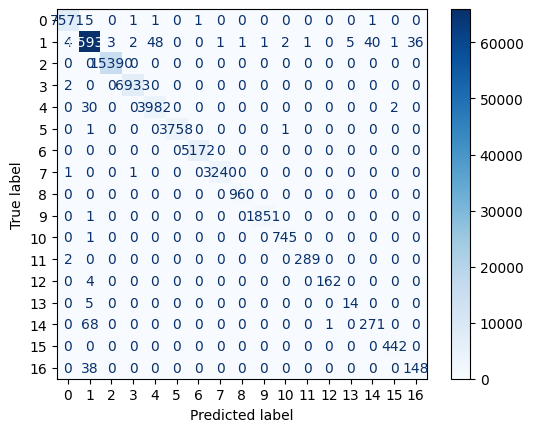

Classes:  class2
Training | Exp. E1.1__results.pkl | Classes class2
Testing | Exp. E1.1__results.pkl | Classes class2
Tiempo test:  0.01662921905517578
Accuracy:   0.9975080433873542
Precision:  0.9959474261803941
Recall:     0.9937627166629233
F1:         0.9948469511822862


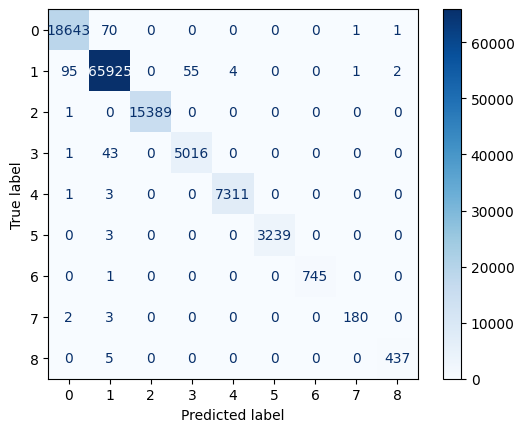

Classes:  class3
Training | Exp. E1.1__results.pkl | Classes class3
Testing | Exp. E1.1__results.pkl | Classes class3
Tiempo test:  0.014809131622314453
Accuracy:   0.9973032250356298
Precision:  0.9972190632248833
Recall:     0.9972983241124278
F1:         0.9972585948223875


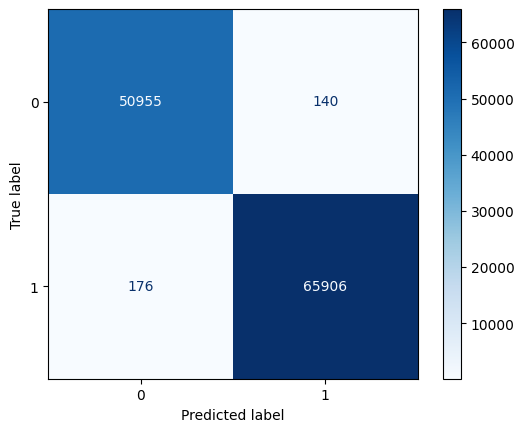

Experiment:  E1.2__results.pkl
Classes:  class1
Training | Exp. E1.2__results.pkl | Classes class1
Testing | Exp. E1.2__results.pkl | Classes class1
Tiempo test:  0.0185089111328125
Accuracy:   0.9972349522517218
Precision:  0.9670224055114526
Recall:     0.9621502167159807
F1:         0.9645032835956189


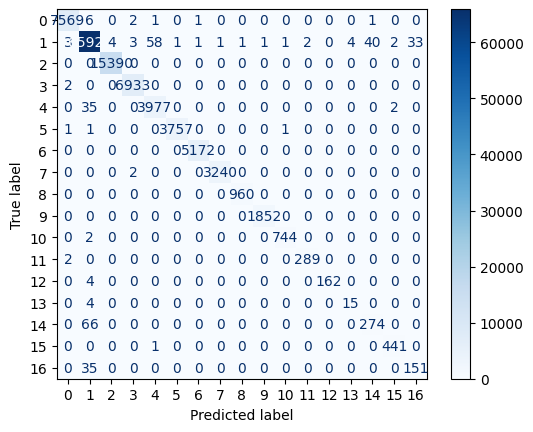

Classes:  class2
Training | Exp. E1.2__results.pkl | Classes class2
Testing | Exp. E1.2__results.pkl | Classes class2
Tiempo test:  0.016448020935058594
Accuracy:   0.9973629637215494
Precision:  0.9943295142826235
Recall:     0.993667303174591
F1:         0.9939971657924883


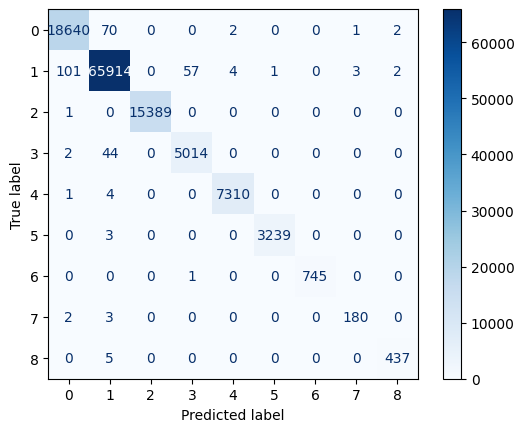

Classes:  class3
Training | Exp. E1.2__results.pkl | Classes class3
Testing | Exp. E1.2__results.pkl | Classes class3
Tiempo test:  0.01450967788696289
Accuracy:   0.9973373614275839
Precision:  0.997253761794174
Recall:     0.9973330282129615
F1:         0.9972932961537497


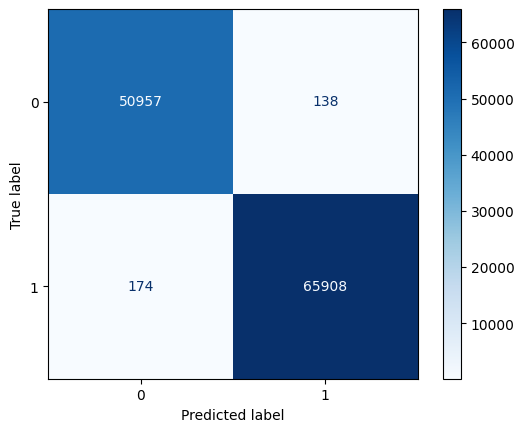

Experiment:  E1.3__results.pkl
Classes:  class1
Mean features: 26.2
Training | Exp. E1.3__results.pkl | Classes class1
Testing | Exp. E1.3__results.pkl | Classes class1
Tiempo test:  0.012385129928588867
Accuracy:   0.9965607585106292
Precision:  0.9721932288867928
Recall:     0.9553095022730458
F1:         0.9630252033291372


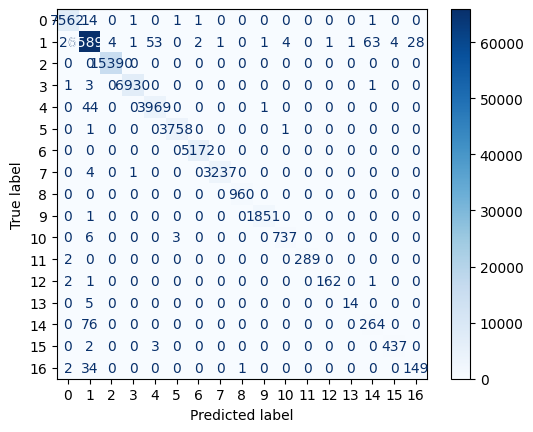

Classes:  class2
Mean features: 24.6
Training | Exp. E1.3__results.pkl | Classes class2
Testing | Exp. E1.3__results.pkl | Classes class2
Tiempo test:  0.011786937713623047
Accuracy:   0.9963047355709739
Precision:  0.9908109341216425
Recall:     0.9919057317388796
F1:         0.9913542055922969


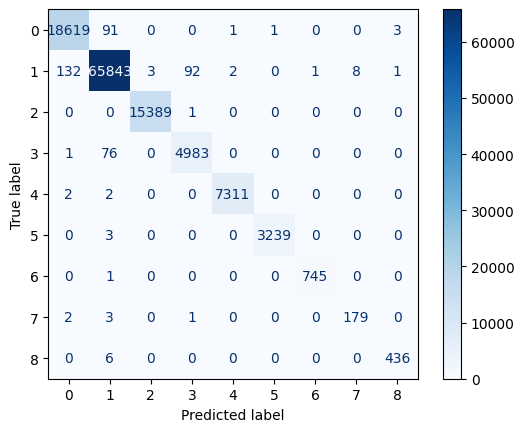

Classes:  class3
Mean features: 29.0
Training | Exp. E1.3__results.pkl | Classes class3
Testing | Exp. E1.3__results.pkl | Classes class3
Tiempo test:  0.010660409927368164
Accuracy:   0.9971666794678137
Precision:  0.9970586110256067
Recall:     0.9971817010739523
F1:         0.9971199169318563


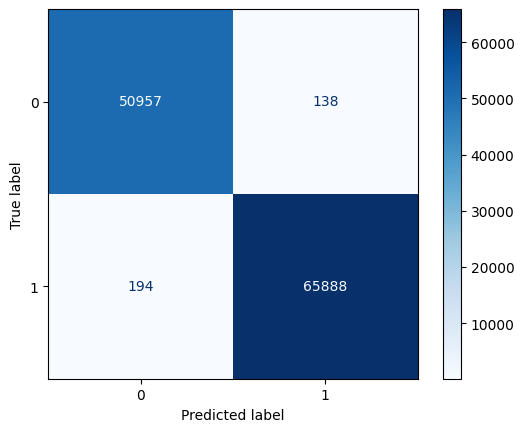

Experiment:  E1.4__results.pkl
Classes:  class1
Mean features: 15.4
Training | Exp. E1.4__results.pkl | Classes class1
Testing | Exp. E1.4__results.pkl | Classes class1
Tiempo test:  0.013272523880004883
Accuracy:   0.9892299683384964
Precision:  0.9300678187098814
Recall:     0.9169066625663121
F1:         0.9224456071161146


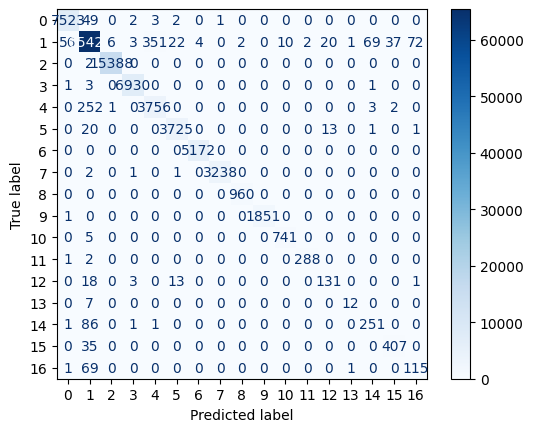

Classes:  class2
Mean features: 11.2
Training | Exp. E1.4__results.pkl | Classes class2
Testing | Exp. E1.4__results.pkl | Classes class2
Tiempo test:  0.009426593780517578
Accuracy:   0.994742995639076
Precision:  0.989487380288665
Recall:     0.9890037078929357
F1:         0.9892433842711955


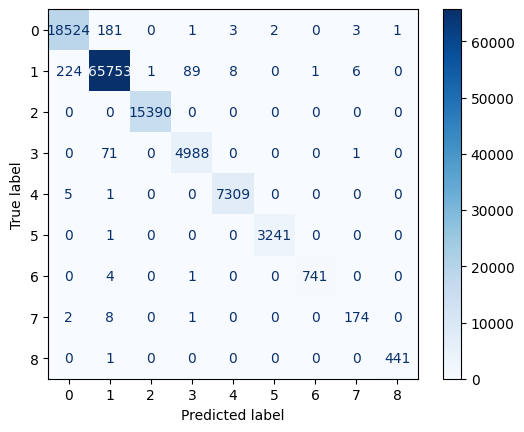

Classes:  class3
Mean features: 12.0
Training | Exp. E1.4__results.pkl | Classes class3
Testing | Exp. E1.4__results.pkl | Classes class3
Tiempo test:  0.0084381103515625
Accuracy:   0.9948795412068921
Precision:  0.9947683946007478
Recall:     0.994821016956343
F1:         0.994794661955458


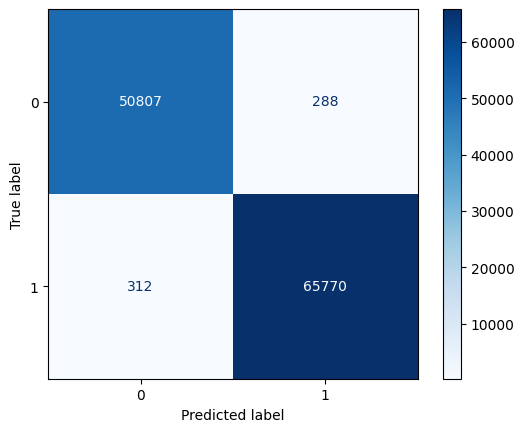

Experiment:  E2.1__results.pkl
Classes:  class1
Training | Exp. E2.1__results.pkl | Classes class1
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1725 - accuracy: 0.9463
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0809 - accuracy: 0.9723
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0631 - accuracy: 0.9771
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0542 - accuracy: 0.9794
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0490 - accuracy: 0.9810
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0457 - accuracy: 0.9821
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0436 - accuracy: 0.9828
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0419 - accuracy: 0.9832
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0407 - 

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 2s 485us/step
Tiempo test:  2.284712553024292
Accuracy:   0.9841948505252738
Precision:  0.9737282813887783
Recall:     0.8828177551328641
F1:         0.9069011811834841


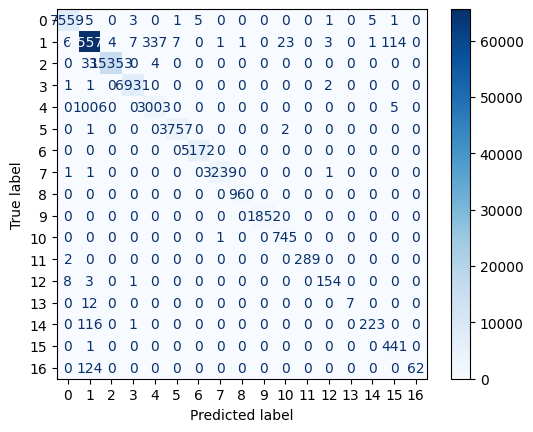

Classes:  class2
Training | Exp. E2.1__results.pkl | Classes class2
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1269 - accuracy: 0.9624
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0658 - accuracy: 0.9781
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0558 - accuracy: 0.9796
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0501 - accuracy: 0.9809
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0465 - accuracy: 0.9820
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0444 - accuracy: 0.9824
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0428 - accuracy: 0.9831
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0409 - accuracy: 0.9837
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0400 - accuracy: 0.9840
Epoch 10/10
18

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 2s 490us/step
Tiempo test:  2.1380069255828857
Accuracy:   0.9846044872287224
Precision:  0.9914672476024554
Recall:     0.9309476147201886
F1:         0.956437268505156


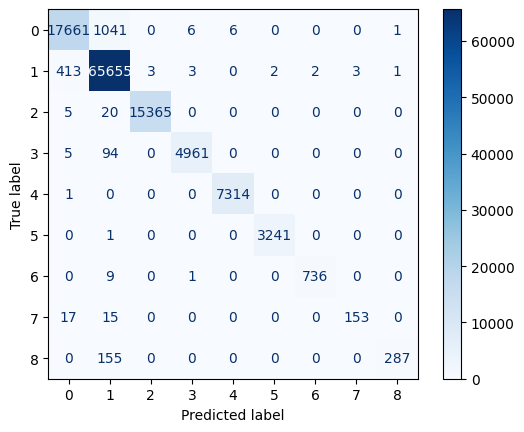

Classes:  class3
Training | Exp. E2.1__results.pkl | Classes class3
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0901 - accuracy: 0.9714
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0573 - accuracy: 0.9798
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0501 - accuracy: 0.9807
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0459 - accuracy: 0.9816
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0435 - accuracy: 0.9825
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0417 - accuracy: 0.9831
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0401 - accuracy: 0.9838
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0392 - accuracy: 0.9841
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0383 - accuracy: 0.9845
Epoch 10/10
18

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 1s 399us/step
Tiempo test:  1.8000900745391846
Accuracy:   0.9848007714824581
Precision:  0.9859858068316736
Recall:     0.9832374811133172
F1:         0.9845057882445929


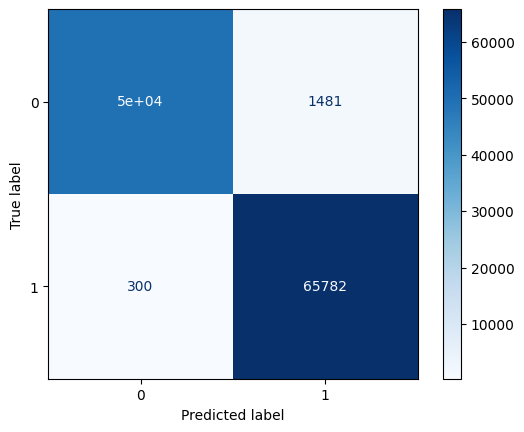

Experiment:  E2.2__results.pkl
Classes:  class1
Training | Exp. E2.2__results.pkl | Classes class1
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1740 - accuracy: 0.9457
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0805 - accuracy: 0.9721
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0631 - accuracy: 0.9770
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0541 - accuracy: 0.9795
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0487 - accuracy: 0.9811
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0455 - accuracy: 0.9821
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0432 - accuracy: 0.9828
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0418 - accuracy: 0.9834
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0403 - 

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 2s 491us/step
Tiempo test:  2.1381711959838867
Accuracy:   0.9843399301910785
Precision:  0.9254830619674593
Recall:     0.9164451344841015
F1:         0.9049974197123154


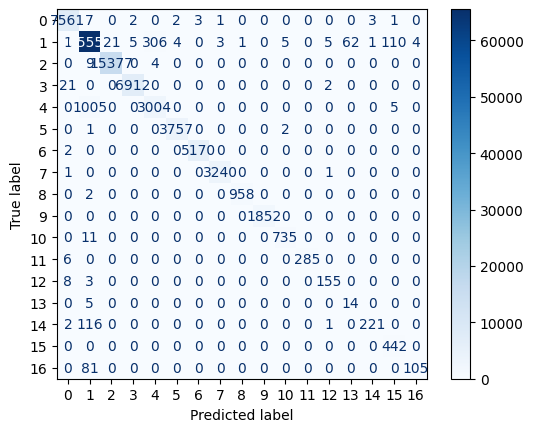

Classes:  class2
Training | Exp. E2.2__results.pkl | Classes class2
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1298 - accuracy: 0.9612
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0660 - accuracy: 0.9780
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0559 - accuracy: 0.9795
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0504 - accuracy: 0.9811
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0467 - accuracy: 0.9818
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0445 - accuracy: 0.9825
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0427 - accuracy: 0.9831
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0412 - accuracy: 0.9835
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0401 - accuracy: 0.9840
Epoch 10/10
18

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 2s 484us/step
Tiempo test:  2.122800588607788
Accuracy:   0.9851421354019987
Precision:  0.9688133104474831
Recall:     0.9702826719052999
F1:         0.9679273809369988


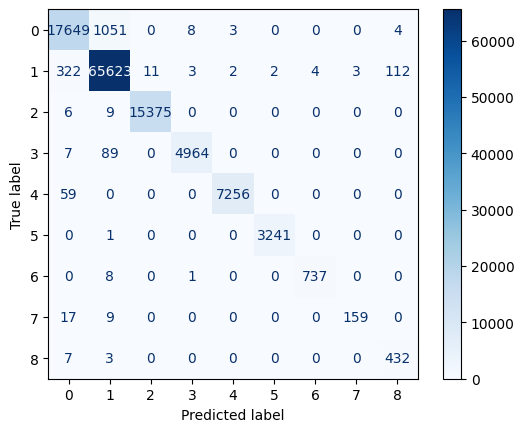

Classes:  class3
Training | Exp. E2.2__results.pkl | Classes class3
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0922 - accuracy: 0.9702
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0564 - accuracy: 0.9799
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0491 - accuracy: 0.9811
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0453 - accuracy: 0.9819
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0433 - accuracy: 0.9825
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0413 - accuracy: 0.9833
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0401 - accuracy: 0.9838
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0390 - accuracy: 0.9840
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0385 - accuracy: 0.9841
Epoch 10/10
18

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 1s 402us/step
Tiempo test:  1.801628828048706
Accuracy:   0.9856029766933784
Precision:  0.9863788927722177
Recall:     0.9844036826216729
F1:         0.9853345795456887


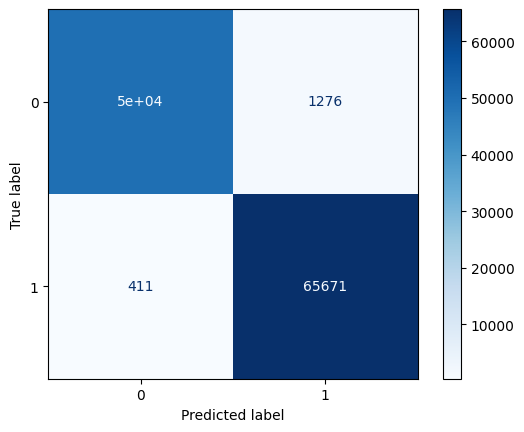

Experiment:  E2.3__results.pkl
Classes:  class1
Mean features: 27.2
Training | Exp. E2.3__results.pkl | Classes class1
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2605 - accuracy: 0.9146
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1209 - accuracy: 0.9553
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1005 - accuracy: 0.9604
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0894 - accuracy: 0.9638
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0827 - accuracy: 0.9662
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0776 - accuracy: 0.9686
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0742 - accuracy: 0.9696
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0705 - accuracy: 0.9713
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/st

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 2s 478us/step
Tiempo test:  2.07200288772583
Accuracy:   0.970079452452273
Precision:  0.9041563779314845
Recall:     0.8296791018883906
F1:         0.8502023095845256


/home/ubuntu2202/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


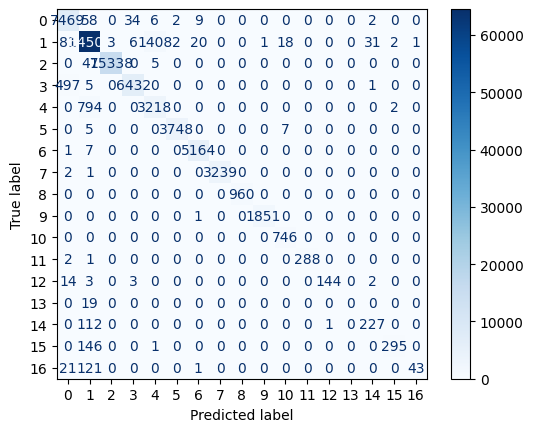

Classes:  class2
Mean features: 27.4
Training | Exp. E2.3__results.pkl | Classes class2
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2110 - accuracy: 0.9295
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1099 - accuracy: 0.9621
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0965 - accuracy: 0.9662
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0897 - accuracy: 0.9677
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0851 - accuracy: 0.9691
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0819 - accuracy: 0.9698
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0798 - accuracy: 0.9706
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0779 - accuracy: 0.9710
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0762 - accuracy: 0

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 2s 488us/step
Tiempo test:  2.1128358840942383
Accuracy:   0.9738771260571614
Precision:  0.9663424125906599
Recall:     0.9463474805519032
F1:         0.9513806392341936


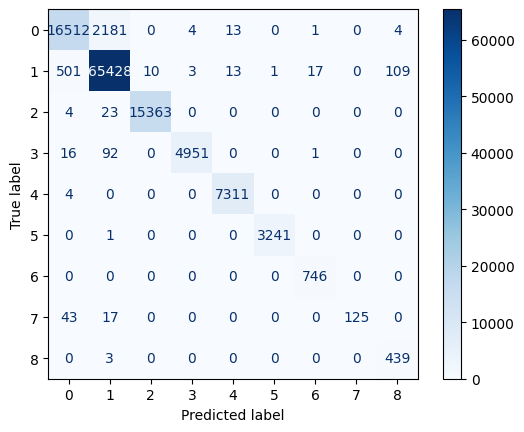

Classes:  class3
Mean features: 29.2
Training | Exp. E2.3__results.pkl | Classes class3
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1502 - accuracy: 0.9447
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0851 - accuracy: 0.9669
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0730 - accuracy: 0.9701
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0671 - accuracy: 0.9719
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0634 - accuracy: 0.9733
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0612 - accuracy: 0.9741
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0595 - accuracy: 0.9751
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0581 - accuracy: 0.9752
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0569 - accuracy: 0

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 1s 386us/step
Tiempo test:  1.7332017421722412
Accuracy:   0.9750462974815877
Precision:  0.9744133609746247
Recall:     0.9748820875192474
F1:         0.9746439244662902


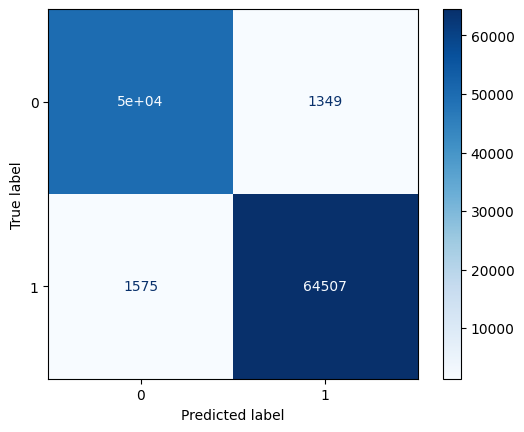

Experiment:  E2.4__results.pkl
Classes:  class1
Mean features: 13.6
Training | Exp. E2.4__results.pkl | Classes class1
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4331 - accuracy: 0.8532
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2604 - accuracy: 0.9081
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2158 - accuracy: 0.9241
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1895 - accuracy: 0.9322
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1734 - accuracy: 0.9372
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1619 - accuracy: 0.9407
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1530 - accuracy: 0.9434
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1463 - accuracy: 0.9461
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/st

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 2s 475us/step
Tiempo test:  2.0554583072662354
Accuracy:   0.9461754439864478
Precision:  0.859265917113595
Recall:     0.7263727459582865
F1:         0.7647792412063918


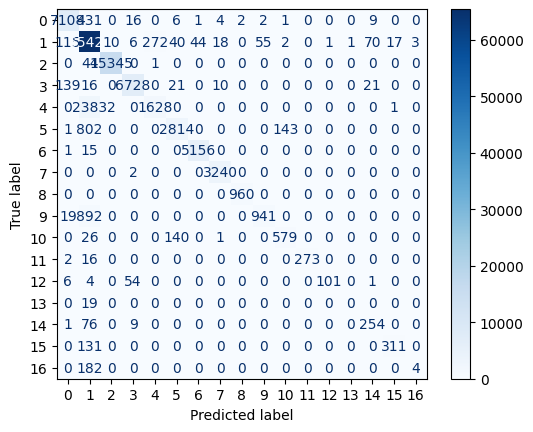

Classes:  class2
Mean features: 12.2
Training | Exp. E2.4__results.pkl | Classes class2
Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4275 - accuracy: 0.8376
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2783 - accuracy: 0.8913
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2341 - accuracy: 0.9109
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2072 - accuracy: 0.9236
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1891 - accuracy: 0.9311
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1771 - accuracy: 0.9363
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1685 - accuracy: 0.9394
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1619 - accuracy: 0.9422
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1552 - accuracy: 0

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 2s 475us/step
Tiempo test:  2.0563735961914062
Accuracy:   0.9387251764424759
Precision:  0.9313740437900024
Recall:     0.8997393702266252
F1:         0.9083946563400082


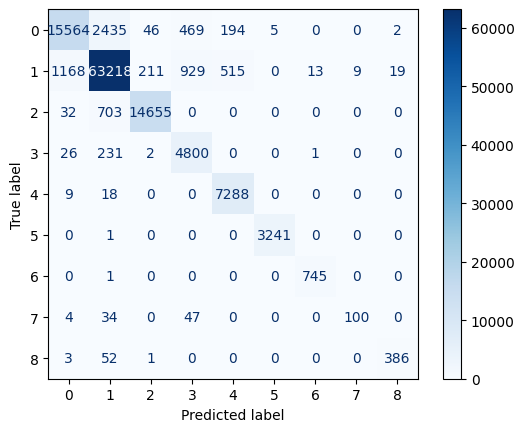

Classes:  class3
Mean features: 12.2
Training | Exp. E2.4__results.pkl | Classes class3
Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3925 - accuracy: 0.7935
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2573 - accuracy: 0.8896
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2284 - accuracy: 0.9057
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2126 - accuracy: 0.9148
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1997 - accuracy: 0.9217
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1910 - accuracy: 0.9260
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1838 - accuracy: 0.9288
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1774 - accuracy: 0.9313
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1711 - accuracy: 0

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 1s 372us/step
Tiempo test:  1.6775634288787842
Accuracy:   0.9473019449209316
Precision:  0.9477799205053968
Recall:     0.9449929631769729
F1:         0.9462649539769761


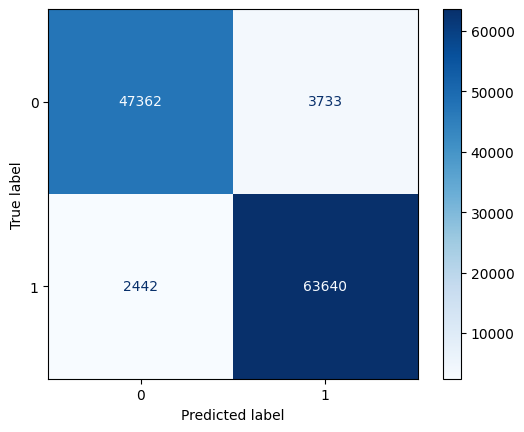

Experiment:  E3.1__results.pkl
Classes:  class1
Training | Exp. E3.1__results.pkl | Classes class1
Epoch 1/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1582 - accuracy: 0.9528
Epoch 2/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0648 - accuracy: 0.9776
Epoch 3/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0488 - accuracy: 0.9815
Epoch 4/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0408 - accuracy: 0.9839
Epoch 5/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0362 - accuracy: 0.9856
Epoch 6/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0337 - accuracy: 0.9863
Epoch 7/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0317 - accuracy: 0.9873
Epoch 8/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0299 - accuracy: 0.9879
Epoch 9/10
1875/1875 [==============================] - 27s 14ms/step

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 5s 1ms/step
Tiempo test:  5.090079307556152
Accuracy:   0.9875487510347594
Precision:  0.9231750656042255
Recall:     0.968227165955327
F1:         0.9430104489245568


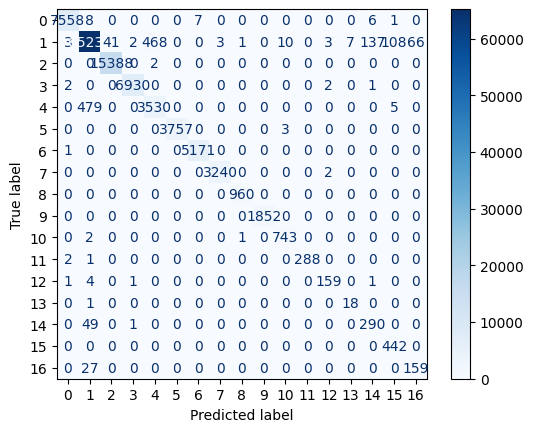

Classes:  class2
Training | Exp. E3.1__results.pkl | Classes class2
Epoch 1/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.1213 - accuracy: 0.9654
Epoch 2/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0568 - accuracy: 0.9800
Epoch 3/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0463 - accuracy: 0.9822
Epoch 4/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0395 - accuracy: 0.9844
Epoch 5/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0356 - accuracy: 0.9858
Epoch 6/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0330 - accuracy: 0.9867
Epoch 7/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0311 - accuracy: 0.9875
Epoch 8/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0298 - accuracy: 0.9882
Epoch 9/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0284 - accuracy: 0.9

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 5s 1ms/step
Tiempo test:  5.101473808288574
Accuracy:   0.9875572851327479
Precision:  0.9812499880340612
Recall:     0.9773606327658998
F1:         0.9792371311325518


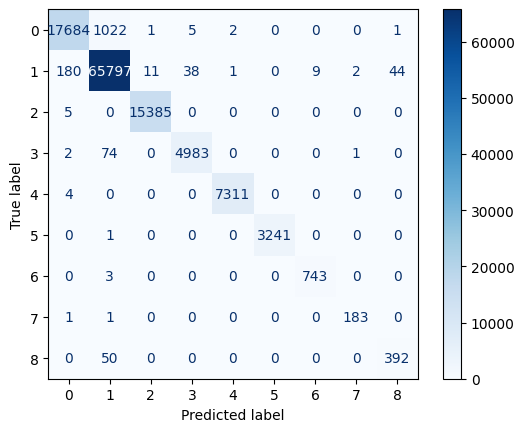

Classes:  class3
Training | Exp. E3.1__results.pkl | Classes class3
Epoch 1/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0933 - accuracy: 0.9687
Epoch 2/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0461 - accuracy: 0.9820
Epoch 3/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0387 - accuracy: 0.9845
Epoch 4/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0350 - accuracy: 0.9859
Epoch 5/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0323 - accuracy: 0.9868
Epoch 6/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0304 - accuracy: 0.9875
Epoch 7/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0289 - accuracy: 0.9881
Epoch 8/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0277 - accuracy: 0.9886
Epoch 9/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0269 - accuracy: 0.9

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 5s 1ms/step
Tiempo test:  4.932880878448486
Accuracy:   0.9883253539517141
Precision:  0.9892414378506753
Recall:     0.9871014255437054
F1:         0.9881059428711313


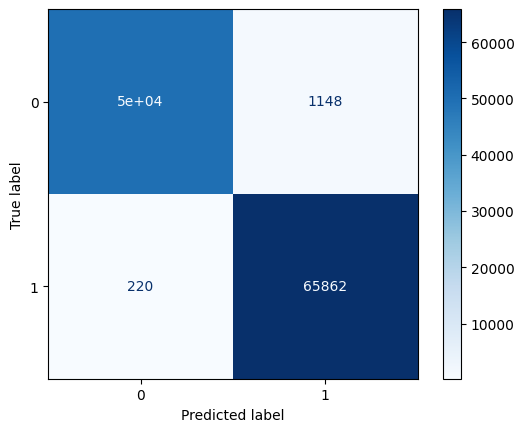

Experiment:  E3.2__results.pkl
Classes:  class1
Training | Exp. E3.2__results.pkl | Classes class1
Epoch 1/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1509 - accuracy: 0.9546
Epoch 2/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0618 - accuracy: 0.9782
Epoch 3/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0479 - accuracy: 0.9819
Epoch 4/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0402 - accuracy: 0.9841
Epoch 5/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0356 - accuracy: 0.9858
Epoch 6/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0321 - accuracy: 0.9870
Epoch 7/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0303 - accuracy: 0.9880
Epoch 8/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0289 - accuracy: 0.9886
Epoch 9/10
1875/1875 [==============================] - 26s 14ms/step

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 5s 1ms/step
Tiempo test:  4.9287965297698975
Accuracy:   0.9880266605221161
Precision:  0.9836116091065465
Recall:     0.8862077146464198
F1:         0.9199873373921312


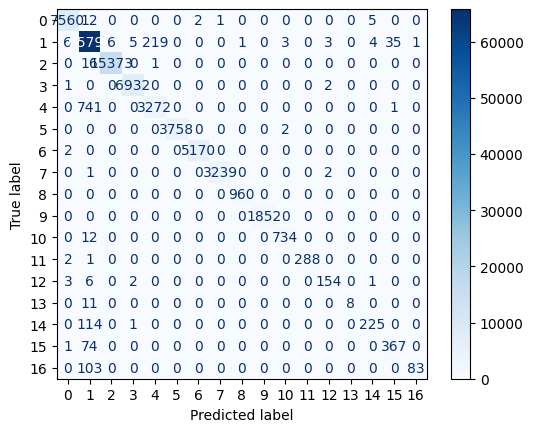

Classes:  class2
Training | Exp. E3.2__results.pkl | Classes class2
Epoch 1/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1231 - accuracy: 0.9643
Epoch 2/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0555 - accuracy: 0.9802
Epoch 3/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0457 - accuracy: 0.9825
Epoch 4/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0408 - accuracy: 0.9841
Epoch 5/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0372 - accuracy: 0.9854
Epoch 6/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0345 - accuracy: 0.9863
Epoch 7/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0320 - accuracy: 0.9871
Epoch 8/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0302 - accuracy: 0.9878
Epoch 9/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0289 - accuracy: 0.9

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 5s 1ms/step
Tiempo test:  4.98531174659729
Accuracy:   0.9890934227706802
Precision:  0.9811594826663382
Recall:     0.9829942738034485
F1:         0.9820595834439376


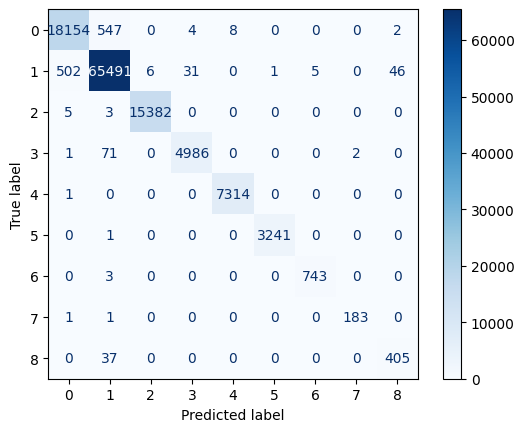

Classes:  class3
Training | Exp. E3.2__results.pkl | Classes class3
Epoch 1/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0943 - accuracy: 0.9680
Epoch 2/10
1875/1875 [==============================] - 25s 14ms/step - loss: 0.0495 - accuracy: 0.9812
Epoch 3/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0412 - accuracy: 0.9837
Epoch 4/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0360 - accuracy: 0.9854
Epoch 5/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0333 - accuracy: 0.9865
Epoch 6/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0315 - accuracy: 0.9872
Epoch 7/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0301 - accuracy: 0.9878
Epoch 8/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0289 - accuracy: 0.9882
Epoch 9/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0278 - accuracy: 0.9

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 5s 1ms/step
Tiempo test:  5.285968780517578
Accuracy:   0.9892811729264276
Precision:  0.9892854368313357
Recall:     0.9889164881776957
F1:         0.9890988251647744


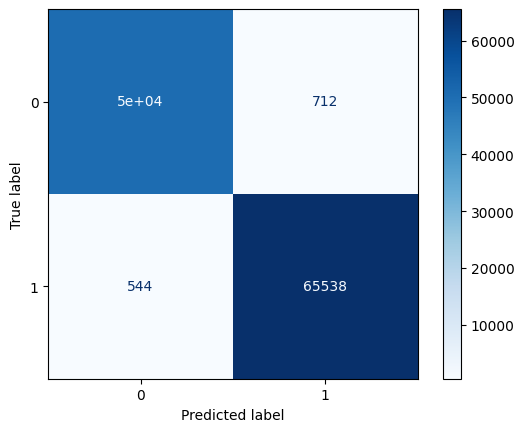

Experiment:  E3.3__results.pkl
Classes:  class1
Mean features: 30.8
Training | Exp. E3.3__results.pkl | Classes class1
Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2298 - accuracy: 0.9212
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1033 - accuracy: 0.9600
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0822 - accuracy: 0.9671
Epoch 4/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0706 - accuracy: 0.9718
Epoch 5/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0629 - accuracy: 0.9747
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0588 - accuracy: 0.9764
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0560 - accuracy: 0.9775
Epoch 8/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0544 - accuracy: 0.9781
Epoch 9/10
1875/1875 [==============================] - 1

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 4s 1ms/step
Tiempo test:  4.704348087310791
Accuracy:   0.9783831297950963
Precision:  0.9678423410108451
Recall:     0.8706208951733992
F1:         0.8892553705891174


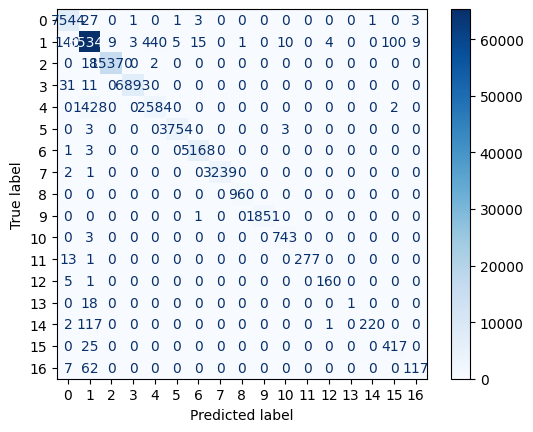

Classes:  class2
Mean features: 25.4
Training | Exp. E3.3__results.pkl | Classes class2
Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2131 - accuracy: 0.9275
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0985 - accuracy: 0.9657
Epoch 3/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0862 - accuracy: 0.9687
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0794 - accuracy: 0.9699
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0723 - accuracy: 0.9713
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0675 - accuracy: 0.9729
Epoch 7/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0641 - accuracy: 0.9742
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0618 - accuracy: 0.9748
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0596 - ac

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 4s 1ms/step
Tiempo test:  4.069415807723999
Accuracy:   0.977879618013774
Precision:  0.970154766889178
Recall:     0.9448781587057344
F1:         0.9538410493491225


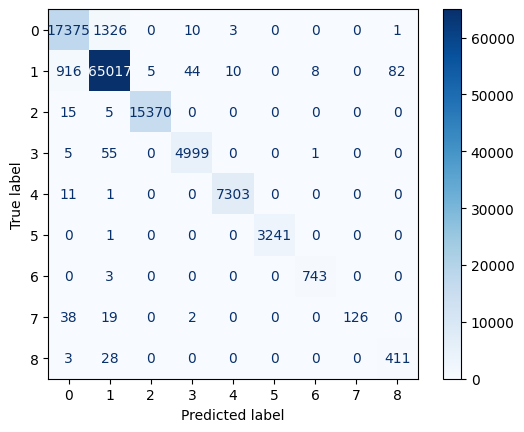

Classes:  class3
Mean features: 28.0
Training | Exp. E3.3__results.pkl | Classes class3
Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1411 - accuracy: 0.9452
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0758 - accuracy: 0.9697
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0659 - accuracy: 0.9734
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0610 - accuracy: 0.9751
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0573 - accuracy: 0.9761
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0551 - accuracy: 0.9770
Epoch 7/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0535 - accuracy: 0.9777
Epoch 8/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0525 - accuracy: 0.9778
Epoch 9/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0515 - ac

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 4s 1ms/step
Tiempo test:  4.707804441452026
Accuracy:   0.9777430724459578
Precision:  0.9793861071170941
Recall:     0.9755819220047635
F1:         0.9772871881280067


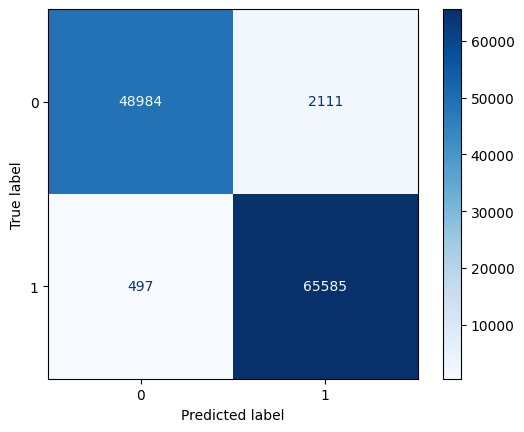

Experiment:  E3.4__results.pkl
Classes:  class1
Mean features: 13.6
Training | Exp. E3.4__results.pkl | Classes class1
Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.6772 - accuracy: 0.7853
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4689 - accuracy: 0.8434
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3973 - accuracy: 0.8668
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3206 - accuracy: 0.8939
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2430 - accuracy: 0.9200
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2061 - accuracy: 0.9315
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1850 - accuracy: 0.9382
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1719 - accuracy: 0.9421
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/st

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 3s 898us/step
Tiempo test:  3.6664655208587646
Accuracy:   0.9531819384350171
Precision:  0.7727491175208454
Recall:     0.6112667541867628
F1:         0.6441466558965299


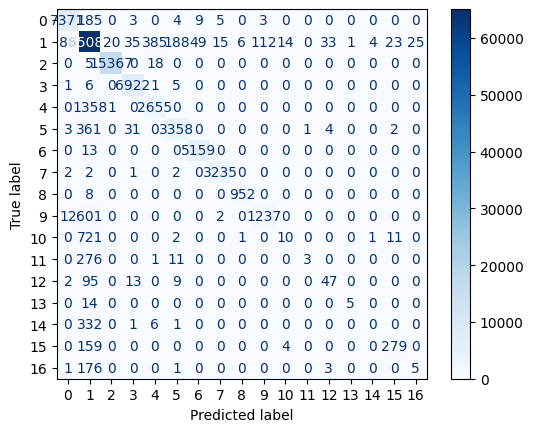

Classes:  class2
Mean features: 14.8
Training | Exp. E3.4__results.pkl | Classes class2
Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2779 - accuracy: 0.9000
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1453 - accuracy: 0.9495
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1235 - accuracy: 0.9554
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1114 - accuracy: 0.9596
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1024 - accuracy: 0.9625
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0964 - accuracy: 0.9646
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0912 - accuracy: 0.9663
Epoch 8/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0878 - accuracy: 0.9673
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0844 - accuracy:

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 4s 979us/step
Tiempo test:  3.9524776935577393
Accuracy:   0.9678861892692252
Precision:  0.9260426405110967
Recall:     0.9108491789234964
F1:         0.912066455475569


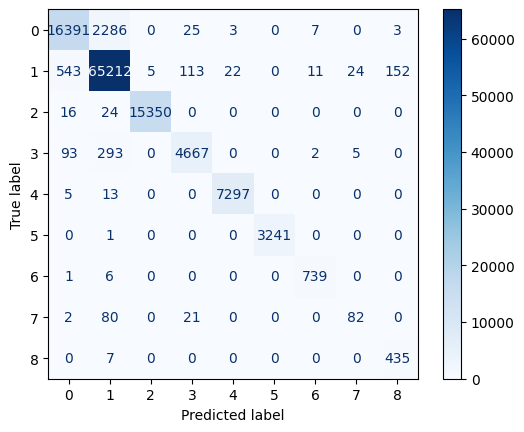

Classes:  class3
Mean features: 14.6
Training | Exp. E3.4__results.pkl | Classes class3
Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2241 - accuracy: 0.9165
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1627 - accuracy: 0.9358
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1366 - accuracy: 0.9441
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1206 - accuracy: 0.9517
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1103 - accuracy: 0.9562
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1033 - accuracy: 0.9585
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0991 - accuracy: 0.9602
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0952 - accuracy: 0.9616
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0921 - accuracy: 

/home/ubuntu2202/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3662/3662 [==============================] - 4s 946us/step
Tiempo test:  3.816056251525879
Accuracy:   0.9518762214427746
Precision:  0.95527514466959
Recall:     0.9475859878372785
F1:         0.9506956510165955


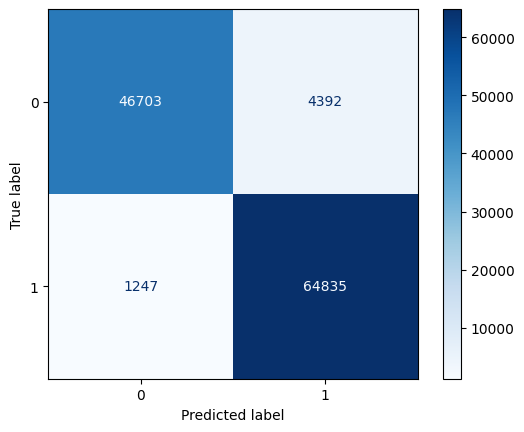

In [28]:
scaler = MinMaxScaler()

exp_names = ['E1.1__results.pkl','E1.2__results.pkl','E1.3__results.pkl','E1.4__results.pkl',
        'E2.1__results.pkl','E2.2__results.pkl','E2.3__results.pkl','E2.4__results.pkl',
        'E3.1__results.pkl','E3.2__results.pkl','E3.3__results.pkl','E3.4__results.pkl']

keys = ['class1', 'class2', 'class3']
exclude_cols = ['class1', 'class2', 'class3', 'Date', 'Timestamp', 'Scr_IP', 'Des_IP']

X_orig = data.drop(columns=exclude_cols)

# iterar sobre experimentos
for exp in exp_names:
    print('Experiment: ', exp)
    # Cargar el archivo .pkl
    with open('resultados_exp/' + exp, 'rb') as file:
        exp_results = pickle.load(file)

    # iterar sobre tipos de clases
    for key in keys:
        print('Classes: ', key)
        
        ### Filtrar features ###
        if '.3' in exp or '.4' in exp:
            freq_feat = get_frequent_features(exp_results[key]['features']) # features frecuentes del experimento/clase
            X_mod = X_orig.iloc[:, freq_feat] # filtar features en X_orig
        elif '.1' in exp:
            X_mod = X_orig
        # dividir sets en train y test
        x_tr, x_te, y_tr, y_te = train_test_split(
                X_mod, data[key].reset_index(drop=True),  # Asegura que el índice sea continuo
                test_size=0.2,
                random_state=42,
                stratify=data[key]
            )
        
        # print('forma x_te', np.shape(x_te))
        # print('forma y_te', np.shape(y_te))

        # print("Valores nulos en y_te antes de escalar:", y_te.isna().sum())
                
        ### eliminar columnas correlacionadas en exp x.2 ###
        if '.2' in exp:
            x_tr = remove_correlated_features(x_tr, 0.99)
            x_te = x_te[x_tr.columns]

        ### Escalar ### el problema es aqui
        x_tr = scaler.fit_transform(x_tr)
        x_te = scaler.transform(x_te)

        # print("Valores nulos en y_te antes de concatenar:", y_te.isna().sum())

        ### Entrenar modelos ###
        # seleccionar clasificador
        if 'E1' in exp:
            classifier = DecisionTreeClassifier()
        elif 'E2' in exp:
            classifier = dnn_model(x_tr.shape[1], y_tr.nunique())
        elif 'E3' in exp:
            classifier = cnn_model_1d(x_tr.shape[1], y_tr.nunique())
        # entrenar
        print(f'Training | Exp. {exp} | Classes {key}')
        if 'E2' in exp or 'E3' in exp:
            classifier.fit(x_tr, y_tr, batch_size=250, epochs=10)
        else:
            classifier.fit(x_tr, y_tr)

        ## Exportar modelo ##
        if isinstance(classifier, DecisionTreeClassifier):
            # Guardar modelo scikit-learn
            with open(f'model_{exp}_{key}.pkl', 'wb') as file:
                pickle.dump(classifier, file)
        elif 'E2' in exp or 'E3' in exp:
            # Guardar modelo de redes neuronales
            classifier.save(f'model_{exp}_{key}.h5')

        ### Testing ###
        # para comparar con jetson
        print(f'Testing | Exp. {exp} | Classes {key}')
        start_time = time.time()
        if 'E2' in exp or 'E3' in exp:
            if key == 'class3':
                start_time = time.time()
                y_pred = (classifier.predict(x_te) > 0.5).astype(int).flatten()
            else:
                start_time = time.time()
                y_pred = np.argmax(classifier.predict(x_te), axis=-1)
        else:
            start_time = time.time()
            y_pred = classifier.predict(x_te)
        test_time = time.time() - start_time        
        print('Tiempo test: ', test_time)
        
        ### Guardar para pruebas en jetson ##
        y_te = np.expand_dims(y_te, axis=1) # Asegurarse de que y_te tenga 2 dimensiones
        test_data = np.concatenate((x_te, y_te), axis=1) # Concatenar los arrays

        y_pred = np.expand_dims(y_pred, axis=1) # Asegurarse de que y_pred tenga 2 dimensiones
        test_data = np.concatenate((test_data, y_pred), axis=1) # Concatenar los arrays

        # Guardar en formato .npy
        np.save(f'{exp}_{key}_test.npy', test_data)

        # print('forma resultado', np.shape(test_data))
        # print(test_data)
        # ultimas_columnas = test_data[:, -2:]
        # nans_por_columna = np.isnan(ultimas_columnas).sum(axis=0) # Contar valores NaN en cada columna
        # print("Valores NaN por columna:", nans_por_columna) # Contar valores NaN en total para las dos columnas
      
        show_metrics(y_te, y_pred)